# Saving and Loading Models

In this notebook, I'll show you how to save and load models with PyTorch. This is important because you'll often want to load previously trained models to use in making predictions or to continue training on new data.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper
# 새로운거 fully connected 모델
import fc_model

In [3]:
# Define a transform to normalize the data
# 데이터 표준화 위한 변환을 정의
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
# 다운로드 train dataset
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
# 다운로드 test dataset. train옵션이 False가 돼 있다.
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Here we can see one of the images.

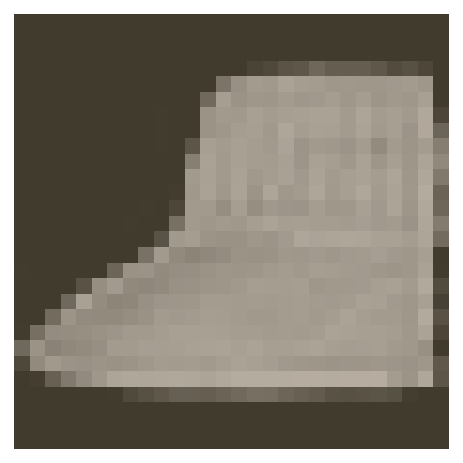

In [4]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

# Train a network

To make things more concise here, I moved the model architecture and training code from the last part to a file called `fc_model`. Importing this, we can easily create a fully-connected network with `fc_model.Network`, and train the network using `fc_model.train`. I'll use this model (once it's trained) to demonstrate how we can save and load models.

In [5]:
# Create the network, define the criterion and optimizer

# 입력 784 (28x28), 출력 10, 512, 256, 128 은 중간 히든 레이어들 노드(유닛) 수.
# 아까 import한 fc_model은 이렇게 쓴다.
model = fc_model.Network(784, 10, [512, 256, 128])

# Loss함수로는 Negative Logarithm Likelihood
criterion = nn.NLLLoss()

# 옵티마이저는 아담, lr은 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
fc_model.train(model, trainloader, testloader, criterion, optimizer, epochs=2)

Epoch: 1/2..  Training Loss: 1.681..  Test Loss: 0.985..  Test Accuracy: 0.635
Epoch: 1/2..  Training Loss: 1.023..  Test Loss: 0.756..  Test Accuracy: 0.714
Epoch: 1/2..  Training Loss: 0.878..  Test Loss: 0.681..  Test Accuracy: 0.747
Epoch: 1/2..  Training Loss: 0.783..  Test Loss: 0.654..  Test Accuracy: 0.749
Epoch: 1/2..  Training Loss: 0.768..  Test Loss: 0.622..  Test Accuracy: 0.759
Epoch: 1/2..  Training Loss: 0.683..  Test Loss: 0.605..  Test Accuracy: 0.773
Epoch: 1/2..  Training Loss: 0.726..  Test Loss: 0.601..  Test Accuracy: 0.778
Epoch: 1/2..  Training Loss: 0.641..  Test Loss: 0.580..  Test Accuracy: 0.785
Epoch: 1/2..  Training Loss: 0.672..  Test Loss: 0.556..  Test Accuracy: 0.794
Epoch: 1/2..  Training Loss: 0.606..  Test Loss: 0.542..  Test Accuracy: 0.797
Epoch: 1/2..  Training Loss: 0.640..  Test Loss: 0.521..  Test Accuracy: 0.805
Epoch: 1/2..  Training Loss: 0.638..  Test Loss: 0.533..  Test Accuracy: 0.798
Epoch: 1/2..  Training Loss: 0.630..  Test Loss: 0.5

## Saving and loading networks

As you can imagine, it's impractical to train a network every time you need to use it. Instead, we can save trained networks then load them later to train more or use them for predictions.

The parameters for PyTorch networks are stored in a model's `state_dict`. We can see the state dict contains the weight and bias matrices for each of our layers.

PyTorch 네트워크의 파라미터는 모델의 state_dict안에 저장된다. state dict는 각 레이어마다의 weight랑 bias 행렬을 저장하고 있다. 사전형이니까 키값이랑 밸류값 가지고 있겠지? 아래 셀 참조.

In [13]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


The simplest thing to do is simply save the state dict with `torch.save`. For example, we can save it to a file `'checkpoint.pth'`.

In [14]:
# 가장 심플하게 저장하는 방법: torch.save. 위에서봤듯, state_dict는 각 레이어의 웨이트바이어스 행렬
torch.save(model.state_dict(), 'checkpoint.pth')

Then we can load the state dict with `torch.load`.

In [15]:
# 불러오기 방법은 torch.load
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


And to load the state dict in to the network, you do `model.load_state_dict(state_dict)`.

In [17]:
# 내가 아까 fc_model써서 정의한 model을 가지고
# 지금 checkpoint.pth에서 읽어들인 state_dict 값 쓰고 싶을 때 아래와 같이게 쓰면 된다.
model.load_state_dict(state_dict)

<All keys matched successfully>

Seems pretty straightforward, but as usual it's a bit more complicated. Loading the state dict works only if the model architecture is exactly the same as the checkpoint architecture. If I create a model with a different architecture, this fails.

모델 레이어 유닛 숫자 다르거나 하면 에러 뜬다. 당연한이야기지만.

In [18]:
# Try this
model = fc_model.Network(784, 10, [400, 200, 100])
# This will throw an error because the tensor sizes are wrong!
model.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for Network:
	size mismatch for hidden_layers.0.weight: copying a param with shape torch.Size([512, 784]) from checkpoint, the shape in current model is torch.Size([400, 784]).
	size mismatch for hidden_layers.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for hidden_layers.1.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([200, 400]).
	size mismatch for hidden_layers.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for hidden_layers.2.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([100, 200]).
	size mismatch for hidden_layers.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for output.weight: copying a param with shape torch.Size([10, 128]) from checkpoint, the shape in current model is torch.Size([10, 100]).

This means we need to rebuild the model exactly as it was when trained. Information about the model architecture needs to be saved in the checkpoint, along with the state dict. To do this, you build a dictionary with all the information you need to compeletely rebuild the model.

당연한 방법이지만, checkpoint.pth 저장할 때, 그냥 무작정 웨이트랑 바이어스 값만 저장하는 게 아니라, Neural Network의 레이어 구조도 같이 저장해 주면 좋겠지? 그래서 아래와 같이 하면 된다. 

In [19]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

Now the checkpoint has all the necessary information to rebuild the trained model. You can easily make that a function if you want. Similarly, we can write a function to load checkpoints. 

약간 귀찮을 수 있겠지만, 아래와 같이 함수 만들어주면, 저장한거 그대로 불러오기 편하다.

In [20]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [21]:
model = load_checkpoint('checkpoint.pth')
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=100, bias=True)
  )
  (output): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
